In [62]:
import random  # for demo script
import os
import argparse
import math
import urllib.request
import io

import IPython
from PIL import Image
import cv2
import matplotlib
import rioxarray

import numpy as np

import geopandas as gpd

import ultralytics
from ultralytics import YOLO
from ultralytics import settings
#ultralytics.checks()
#import wandb
import matplotlib.pyplot as plt

import rasterio as rio
import xarray as xr

In [2]:
os.chdir("/work/csr33/object_detection")
# Update settings
# https://docs.ultralytics.com/quickstart/
os.makedirs('/work/csr33/object_detection/weights', exist_ok=True)
settings.update({'weights_dir': '/work/csr33/object_detection/weights'})

os.makedirs('/work/csr33/object_detection/runs', exist_ok=True)
settings.update({'runs_dir': '/work/csr33/object_detection/runs'})

settings.update({'neptune': False, 'clearml': False, 
                 "raytune": False, #'comet': True, 'raytune': True,
                 'dvc': False, 'hub': False, 'mlflow': False,
                 'tensorboard': False, 'wandb': True})

In [3]:
#Set up wandb
WANDB_API_KEY="006286beb62f8eedc5994d45a84434bf72b09040"
# Name and notes optional
WANDB_NAME="My first run"
WANDB_NOTES="Smaller learning rate, more regularization."
wandb.login()

NameError: name 'wandb' is not defined

In [ ]:
def get_args_parse():
    parser = argparse.ArgumentParser("Exploratory Data Analysis")
    parser.add_argument("--data", default="/hpc/home/csr33/ast_object_detection/ast.yaml", type=str)
    parser.add_argument("--model", default='yolov8n.pt', type=str)
    parser.add_argument("--batch", default=8, type=int)
    parser.add_argument("--imgsz", default=640, type=int)
    parser.add_argument("--epochs", default=2, type=int)
    args = parser.parse_args()
    return args

In [4]:
import sys
sys.argv = ['my_notebook']
args = get_args_parse()

NameError: name 'get_args_parse' is not defined

In [5]:
model_path="/work/csr33/object_detection/runs/detect/baseline_train/weights/best.pt"
item_dim = 640
best_hyper_parameter_yaml = "/work/csr33/object_detection/runs/detect/tune3/best_hyperparameters.yaml"

In [6]:
naip_df = gpd.read_parquet("/work/csr33/images_for_predictions/naip_tile_in_slosh_modeled_area.parquet")

In [7]:
IPython.display.Image(url=naip_df.assets.iloc[0]["image"]["href"])

In [8]:
subset = naip_df.cx[-95.272028:-95.250742, 29.694444:29.736785]

In [98]:
#IPython.display.Image(url = subset.assets.iloc[0]["rendered_preview"]["href"], width=500)

In [14]:
tile.band
#RGBI, red (wavelength) band as band 1, green as band 2, blue as band 3, and near infrared as band 4

#height - width- channel -HWC format with BGR channels uint8 (0-255).

In [ ]:
data_processing(url=subset.assets.iloc[0]["image"]["href"])

In [64]:
def data_processing(url, item_dim=640):
    #read in image
    tile = rioxarray.open_rasterio(url)#.squeeze()
    tile_channels, tile_height, tile_width = tile.shape  # the size of the tile
    # divide the tile into item_dim by item_dim chips (rounding up)
    row_index = math.ceil(tile_height / item_dim)
    col_index = math.ceil(tile_width / item_dim)   
    # determine slices for tile
    slice_indices = [[[x*item_dim, x*item_dim+item_dim], [y*item_dim, y*item_dim+item_dim]] for y in range(row_index) for x in range(col_index)]
    #split tile data array
    split_tile = [tile.isel(x=slice(s[0][0], s[0][1]), y=slice(s[1][0], s[1][1])) for s in slice_indices]
    
    # extract values and format
    split_tile_values = [s.values for s in split_tile]
    split_tile_values = [np.transpose(s, (1, 2, 0)) for s in split_tile_values] #reogrganize CHW to to HWC
    split_tile_values = [s[:, :, [2, 1, 0]] for s in split_tile_values]  # The image is red in as RGB, Swap to BGRR and B channels,  Assuming the array is in RGB format, reverse the channels to get BGR
    split_tile_values = [np.ascontiguousarray(s) for s in split_tile_values]  # ensure the tile is contiguous 
    return split_tile, split_tile_values

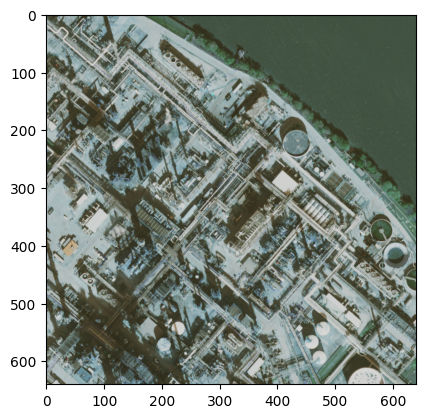

In [153]:
plt.imshow(split_tile_values[159])

In [14]:
model = YOLO(model_path)  # custom trained model 
# Run inference on 'bus.jpg' with arguments
results = model.predict(split_tile_values[160], save=True, imgsz=640, conf=0.5)

# Process results generator
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    probs = result.probs  # Probs object for classification outputs


0: 640x640 1 sedimentation_tank, 2 closed_roof_tanks, 29.7ms
Speed: 3.3ms preprocess, 29.7ms inference, 197.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /work/csr33/object_detection/runs/detect/predict25


In [43]:
xyxy = boxes.xyxy[0]
xyxy = xyxy.cpu().detach().numpy()
xyxy = np.round(xyxy).astype(np.int32) 

In [58]:
split_tile[160].x[xyxy[1]:xyxy[3]]#, xyxy[0]:xyxy[2]]

<xarray.DataArray 'x' (x: 26)>
array([282546.3, 282546.9, 282547.5, 282548.1, 282548.7, 282549.3, 282549.9,
       282550.5, 282551.1, 282551.7, 282552.3, 282552.9, 282553.5, 282554.1,
       282554.7, 282555.3, 282555.9, 282556.5, 282557.1, 282557.7, 282558.3,
       282558.9, 282559.5, 282560.1, 282560.7, 282561.3])
Coordinates:
  * x            (x) float64 2.825e+05 2.825e+05 ... 2.826e+05 2.826e+05
    spatial_ref  int64 0

In [63]:
split_tile[0].rio.crs


CRS.from_epsg(26915)

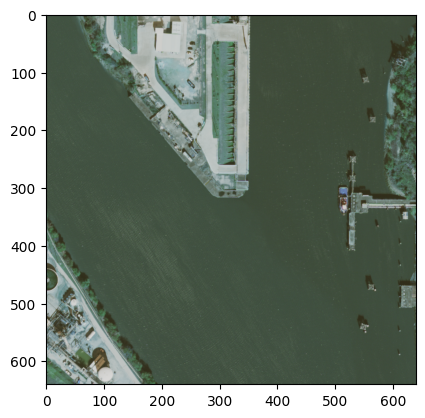

In [47]:
plt.imshow(split_tile_values[160])

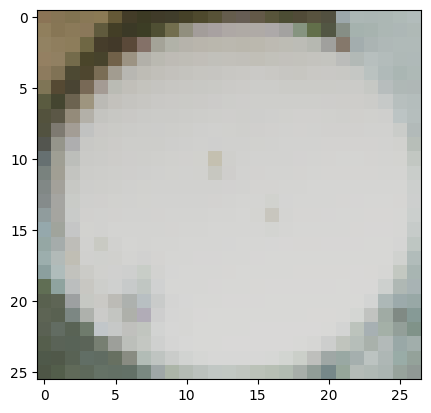

In [51]:
plt.imshow(split_tile_values[160][xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]])

In [30]:
xyxy[0]#:xyxy[2]

89.26401

In [25]:
np.round().astype(int)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
t = tf.constant([1.2, 2.7, 3.14, 4.8])

t_np = t.numpy()
t_rounded_np = 

t_rounded = tf.convert_to_tensor(t_rounded_np)

In [13]:
split_tile_values[160]

In [ ]:
subset = arr
subset

In [160]:
plt.show()

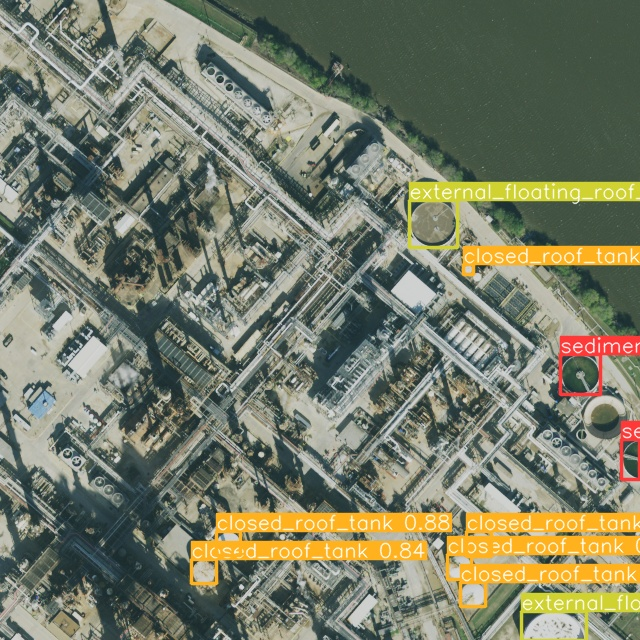

In [161]:
IPython.display.Image("/work/csr33/object_detection/runs/detect/predict21/image0.jpg")

In [91]:
split_tile[0]

<xarray.DataArray (band: 4, y: 640, x: 640)>
array([[[ 82, 116, ..., 104,  98],
        [ 70,  77, ..., 101, 106],
        ...,
        [132,  85, ...,  85,  78],
        [149, 122, ..., 114, 113]],

       [[ 83, 120, ..., 101,  94],
        [ 70,  78, ...,  99, 106],
        ...,
        [125,  79, ...,  89,  79],
        [138, 111, ..., 118, 120]],

       [[ 67, 106, ...,  85,  79],
        [ 54,  64, ...,  85,  92],
        ...,
        [104,  61, ...,  72,  62],
        [110,  83, ...,  98, 102]],

       [[161, 190, ..., 156, 155],
        [150, 158, ..., 156, 167],
        ...,
        [179, 148, ..., 171, 167],
        [184, 169, ..., 191, 194]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 3.387e+05 3.387e+05 ... 3.391e+05 3.391e+05
  * y            (y) float64 4.853e+06 4.853e+06 ... 4.853e+06 4.853e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_ARTIST:            Surdex Corporation, 636-368-4400, www.surdex.com
    TIFFTAG_DATETIME:          2021:11:29 20:52:29
    TIFFTAG_DOCUMENTNAME:      Kezar Falls SW 4307009
    TIFFTAG_HOSTCOMPUTER:      AMDNODE6
    TIFFTAG_IMAGEDESCRIPTION:  Image courtesy of USDA Farm Service Agency's N...
    scale_factor:              1.0
    add_offset:                0.0

In [101]:
.shape

(640, 640, 3)


0: 640x640 (no detections), 37.3ms
Speed: 26.7ms preprocess, 37.3ms inference, 227.8ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
def chip_tiles(self, item_dim): 
    """Segment tiles into item_dim x item_dim pixel chips, preserving resolution
    """
    item_dim = int(512)
    print("chip tiles")
    self.tile_names = os.listdir(self.tiles_dir)  # get a list of all of the tiles in tiles directory
    for tile_name in self.tile_names:  # index over the tiles in the tiles_dir
        print(tile_name)
        tile_name_wo_ext, ext = os.path.splitext(tile_name)  # File name
        tile = cv2.imread(os.path.join(self.tiles_dir, tile_name))
        tile_height, tile_width, tile_channels = tile.shape  # the size of the tile
        # divide the tile into item_dim by item_dim chips (rounding up)
        row_index = math.ceil(tile_height / item_dim)
        col_index = math.ceil(tile_width / item_dim)

        count = 0
        for y in range(0, row_index):
            for x in range(0, col_index):
                # 
                # specify the path to save the image
                chip_img = fc.tile_to_chip_array(tile, x, y, item_dim) #chip tile
                chip_name = tile_name_wo_ext + '_' + f"{y:02}" + '_' + f"{x:02}" + '.jpg'  #
                chips_save_path = os.path.join(self.chips_dir, chip_name)  # row_col.jpg                    
                cv2.imwrite(os.path.join(chips_save_path), chip_img) # save image
                count += 1
        print(count)


In [ ]:
def tile_to_chip_array(tile, x, y, item_dim): #used
    """
    ## https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
    x: col index
    y: row index
    """
    dimensions = tile.shape[2]
    chip_img = tile[y*item_dim:y*item_dim+item_dim, x*(item_dim):x*(item_dim)+item_dim]
    #add in back space if it is the edge of an image
    if (chip_img.shape[0] != item_dim) & (chip_img.shape[1] != item_dim): #width
        #print("Incorrect Width")
        chip = np.zeros((item_dim,item_dim,dimensions), np.uint8)
        chip[0:chip_img.shape[0], 0:chip_img.shape[1]] = chip_img
        chip_img = chip
    if chip_img.shape[0] != item_dim:  #Height
        black_height = item_dim  - chip_img.shape[0] #Height
        black_width = item_dim #- chip_img.shape[1] #width
        black_img = np.zeros((black_height,black_width,  dimensions), np.uint8)
        chip_img = np.concatenate([chip_img, black_img])
    if chip_img.shape[1] != item_dim: #width
        black_height = item_dim #- chip_img.shape[0] #Height
        black_width = item_dim - chip_img.shape[1] #width
        black_img = np.zeros((black_height,black_width, dimensions), np.uint8)
        chip_img = np.concatenate([chip_img, black_img],1)
    return(chip_img)

In [ ]:
numpynp.zeros((640,1280,3))	np.ndarray	HWC format with BGR channels uint8 (0-255).